In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
#read in all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [56]:
#build the dataset

block_size = 3
X, Y = [], []
for w in words:


    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [208]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182424, 5]) torch.Size([182424])
torch.Size([22836, 5]) torch.Size([22836])
torch.Size([22886, 5]) torch.Size([22886])


In [8]:
C = torch.randn((27,2))

In [10]:
C[5] #This (pytorch indexing) is better than 

tensor([-0.5722,  0.8984])

In [9]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C #Writing this

tensor([-0.5722,  0.8984])

In [195]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 20])

In [14]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [25]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #-1 in the view method lets pytorch infer what index the view should be for the operation

In [26]:
h

tensor([[ 0.6550,  0.7770,  0.6824,  ...,  0.8545, -0.8526, -0.1004],
        [ 0.4851, -0.6554,  0.3093,  ...,  0.9725, -0.9815, -0.5930],
        [ 0.9655,  0.5343, -0.9858,  ..., -0.9392, -0.4592, -0.9689],
        ...,
        [ 0.8824, -0.9837, -0.8988,  ...,  0.9890, -0.9986, -0.8117],
        [ 0.9898,  0.1212, -0.9995,  ...,  0.9950, -0.9636, -0.9832],
        [ 0.5168,  0.9835, -0.9968,  ...,  0.9786, -0.6154, -0.1314]])

In [28]:
h.shape

torch.Size([32, 100])

In [29]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [31]:
logits = h @ W2 + b2

In [32]:
logits.shape

torch.Size([32, 27])

In [33]:
counts = logits.exp()

In [34]:
prob = counts / counts.sum(1, keepdims=True)

In [38]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.9224)

In [39]:
# ---------------------- I am going to redo the forward pass and initializations in a cleaner way ------------------------------- #

In [209]:
X.shape, Y.shape #dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [210]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((100,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [211]:
sum(p.nelement() for p in parameters) # number of parameters in total

38967

In [212]:
for p in parameters:
    p.requires_grad=True

In [213]:
lre = torch.linspace(-3, 0, 1000) #learning rate exponent
lrs = 10**lre # All the learning rates we generate

In [214]:
lri = []
lossi = []
stepi = []
for i in range(500000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 100) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

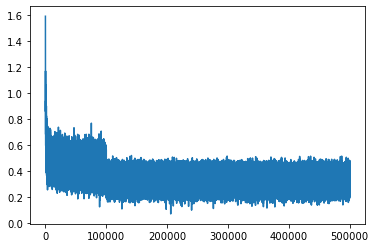

In [215]:
plt.plot(stepi, lossi)

In [217]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 100) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2297, grad_fn=<NllLossBackward0>)

In [218]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 100) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1607, grad_fn=<NllLossBackward0>)

In [151]:
#Sampling
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] *  block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits  = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if(ix == 0):
            break

    print(''.join(itos[i] for i in out))

carpa.
zame.
harif.
jori.
reaty.
sacan.
kejrahnen.
deniya.
jareen.
nelani.
tcerian.
kaleigh.
hamon.
cadeni.
tisroin.
alivebi.
wattar.
dearyni.
jayen.
duratten.
